In [1]:
import pandas as pd
import numpy as np
import time                     #python 自带
from astropy.time import Time   #astropy 
from astropy import units as u 
from astropy import constants as const #import constants 
from astropy.coordinates import cartesian_to_spherical
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
import ligo.skymap.plot

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from moviepy.video.io.bindings import mplfig_to_npimage#动图生成
import moviepy.editor as mpy

from scipy.interpolate import interp1d
from libPattern.fpfc2w import *

# 参数设置

In [2]:
#####源位置###############
NVec = np.array([[-0.21754308, -0.88794532, -0.40525068]]) #randUnitVec(1)

#####其他参数(波形)#############
MassBH    = 1e6       
SpinxBH   = 0
SpinyBH   = 0
SpinzBH   = 0.9
MassCO    = 1e1
SpinxCO   = 0 
SpinyCO   = 0
SpinzCO   = 90
ECC       = 0.5
PM        = 20
IOTA      = 0.25

DURATION = 86400 * 1          #信号持续时间(duration of signal, second) 

# 生成波形及响应函数

In [3]:
#########波形数据##############################################################################################
kwargs = dict(MassBH=MassBH, SpinxBH=SpinxBH, SpinyBH=SpinyBH, SpinzBH=SpinzBH, \
    MassCO=MassCO, SpinxCO=SpinxCO, SpinyCO=SpinyCO, SpinzCO=SpinzCO, ECC=ECC, PM=PM, IOTA=IOTA, DURATION=DURATION)

wave = WaveDataOut(**kwargs)

# wave =  pd.read_csv('./others/waveDataEMRImonth.dat', index_col = 0)  #也可读取csv文件

##########太极轨道数据##############################################################################################
orbitDataTAIJI  =  pd.read_csv('orbitData/orbitDataTAIJI.dat', index_col = 0)  #读取csv文件

ans, thetaPhiPsi = orbitDataProcess(orbitDataTAIJI, NVec) #响应函数 pattern function 输出 timeVec, Fp1, Fc1, Fp2, Fc2
                                                          #以及源的theta, phi, psi
timeVec, Fp1, Fc1, Fp2, Fc2 = ans
theta, phi, psi = thetaPhiPsi

evolution finished, cost 0.003s
omega_mk finished, cost11.347s
hlmk finished, cost 8.863s


# show

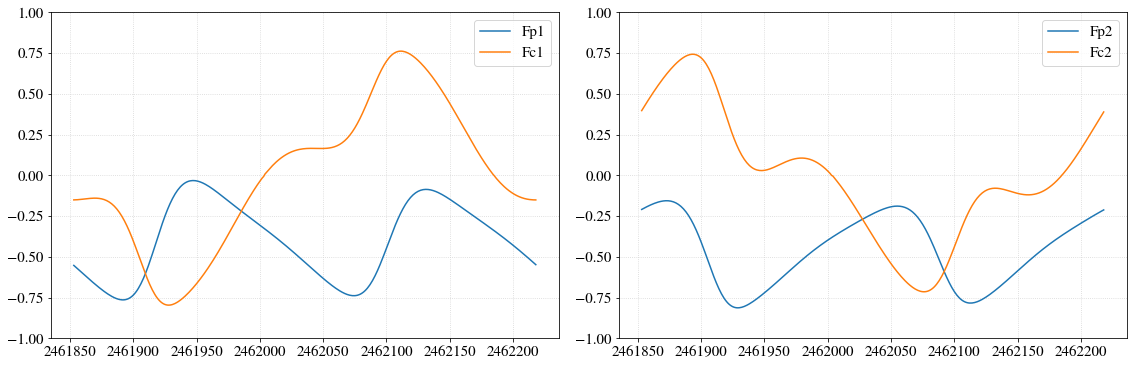

In [4]:
#一年的探测器响应函数
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(16,8/1.5))
plt.subplot(121)
plt.plot(timeVec, Fp1, label='Fp1')
plt.plot(timeVec, Fc1, label='Fc1')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.subplot(122)
plt.plot(timeVec, Fp2, label='Fp2')
plt.plot(timeVec, Fc2, label='Fc2')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.show()

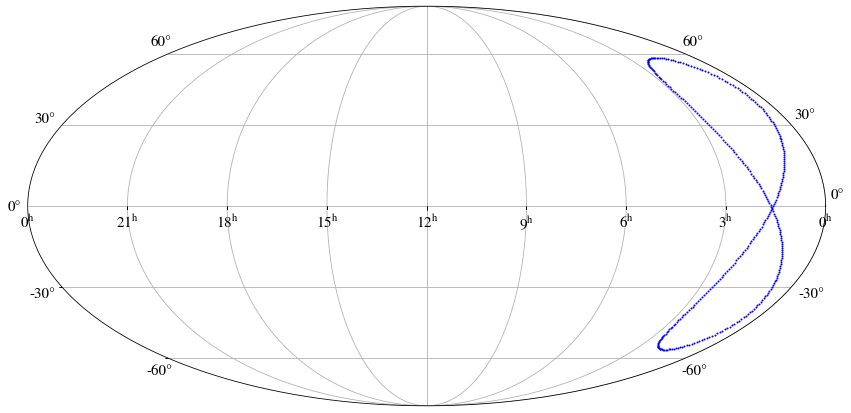

In [5]:
#探测器在天球的位置
source= SkyCoord(phi , np.pi/2 - theta, unit="radian", frame = 'icrs')  # defaults to ICRS frame

matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图
C_center = SkyCoord(8*np.pi/8 , -2*np.pi/8, unit="radian", frame = 'icrs')  # defaults to ICRS frame

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='astro hours mollweide')

ax.plot_coord(source,'o',c='blue',markersize=1)

ax.grid(ax)
plt.tight_layout()
plt.show()

# waveform

In [6]:
#波形绘图准备
timeVecSec = (timeVec - 2461853.0) * 86400  #儒略日换为秒
fp1 =interp1d(timeVecSec, Fp1, kind='cubic')#三次样条插值, Fp1, Fc1插值函数
fc1 =interp1d(timeVecSec, Fc1, kind='cubic')

data  =  wave
fp1Factor = fp1(data['timeSecond'])
fc1Factor = fc1(data['timeSecond'])
ht = np.sqrt(3)/2 * (fp1Factor * data['hp'] + fc1Factor * data['hc'])

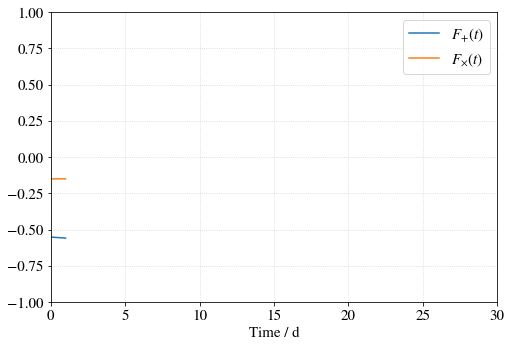

In [7]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(8,8/1.5))
plt.plot(data['timeSecond'], fp1Factor, label='$F_{+}(t)$')
plt.plot(data['timeSecond'], fc1Factor, label='$F_{\\times}(t)$')
plt.ylim(-1, 1)
plt.legend(loc='best')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.xlim(0, 30*86400)
plt.xlabel("Time / d")
plt.xticks([0, 5*86400, 10*86400, 15*86400, 20*86400, 25*86400, 30*86400], ['0', '5','10','15', '20','25', '30'])
plt.show()

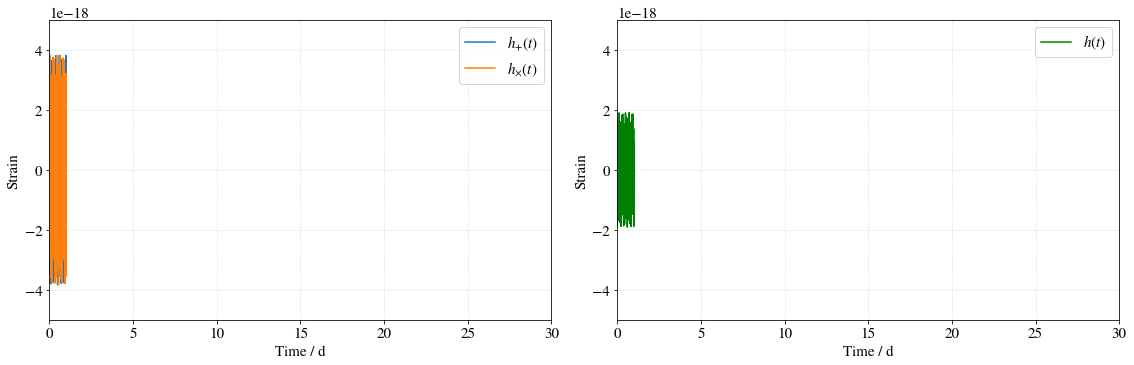

In [8]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

data  =  wave
plt.figure(figsize=(16, 8/1.5))
plt.subplot(121)
plt.plot(data['timeSecond'], data['hp'], label = '$h_{+}(t)$')
plt.plot(data['timeSecond'], data['hc'], label = '$h_{\\times}(t)$')

plt.xlim(0, 30*86400)
plt.xlabel("Time / d")
plt.xticks([0, 5*86400, 10*86400, 15*86400, 20*86400, 25*86400, 30*86400], ['0', '5','10','15', '20','25', '30'])

plt.ylim(- 5e-18, 5e-18)
plt.ylabel("Strain")
plt.legend()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")



plt.subplot(122)
plt.plot(data['timeSecond'],  ht, label = '$h(t)$', c='green')
plt.xlim(0, 30*86400)
plt.xlabel("Time / d")
plt.xticks([0, 5*86400, 10*86400, 15*86400, 20*86400, 25*86400, 30*86400], ['0', '5','10','15', '20','25', '30'])

plt.ylim(- 5e-18, 5e-18)
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()